In [44]:
'''
Author: Van-Cam Nguyen
Email: nguyen.van_cam.no6@is.naist.jp
Conputer Science, Computer Vision
Computing Architecture Lab.
Nara Institute of Science and Technology (NAIST).

This program runs under environment setups:

Jupyter Notebook 6.1.4
Python 3.8.5
tensorflow 2.3.1
keras 2.4.3
pickle 4.0
numpy 1.18.5
matplotlib 3.3.2
'''
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [45]:
# I augment the database by exerting rotation, flip, shift, and zoom operators
# Ref: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

# Data augmentation is a technique to artificially create new training data from the given training dataset. 
# Data augmentation techniques help reducing overfitting and improving accuraccy.
# Ref: https://arxiv.org/pdf/1409.1556.pdf

# We configure rotation, flip, shift, zoom parameters depending on the features of each given dataset. 
# In this experiment, I made the following trials to choose the best parameters subset for the given dataset.

# Trial subsets: (rotation_range, horizontal_flip, width_shift_range, height_shift_range, zoom_range)
# rotation_range     = 5/ 15/ 25
# horizontal_flip    = True
# width_shift_range  = 0.1/ 0.3/ 0.5
# height_shift_range = 0.1/ 0.3/ 0.5
# zoom_range         = 0.1/ 0.3/ 0.5

# The best subset I chose as below:
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.3
    )

def load_data_batch(filename):
    # Loading single batch of dataset 
    with open(filename, 'rb') as batch_file:
        datadict = pickle.load(batch_file, encoding='latin1')
        X = datadict['data']
        Y = datadict['labels']
        Y = np.array(Y)
        return X, Y
    
def load_dataset(DIR):
    # Loading all of dataset from folder
    xs = []
    ys = []
    for index in range(1,6):
        f = os.path.join(DIR, 'data_batch_%d' % (index, ))
        X, Y = load_data_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    return Xtr, Ytr
    
def get_dataset(num_train=45000, num_val=5000):
    # Loading the raw dataset
    # Spliting the given dataset to two subsets for training (45000 images) and validation (5000 images)
    dataset_dir = './ProjectZ/'
    X, Y = load_dataset(dataset_dir)

    # Sub datasets
    X_train = X[0:num_train, :]
    y_train = Y[0:num_train]
    X_val   = X[num_train:(num_train+num_val), :]
    y_val   = Y[num_train:(num_train+num_val)]
    
    ########################################### SOLUTION FOR PROBLEM 0 ####################################################
    
    # Size of the given dataset is (num_images, 3072)
    # Transforming the original size to standard size of images: 
    # (num_images, 3072) => (num_images, n_channel, height, weight) = (num_images, 3, 32, 32)
    # Transposing to have the size as the standard library (matplotlib): (num_images, 3, 32, 32) => (num_images, 32, 32, 3)
    X_train = X_train.reshape(num_train, 3, 32, 32).transpose(0,2,3,1)
    X_val   = X_val.reshape(num_val, 3, 32, 32).transpose(0,2,3,1)

    return X_train, y_train, X_val, y_val

train_images, train_labels, val_images, val_labels = get_dataset()

# The image augmentation is only applied for the training dataset
datagen.fit(train_images)

Text(0.5, 1.0, 'frog')

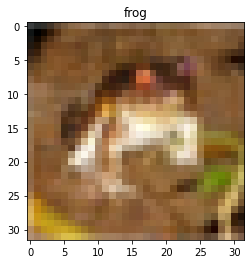

In [46]:
classes_names_file = open("./ProjectZ/classes.names")
classes_names = classes_names_file.read()
classes_names_file.close()
classes_names = list(classes_names.split("\n"))
# Showing the 1st image in the training dataset after converting into matplotlib format (just to check)
image = train_images[0]
label_id = train_labels[0]
plt.imshow(image)
plt.title(classes_names[label_id])

In [47]:
########################################### SOLUTIONS FOR PROBLEM 1 ####################################################

# Pre-processing the input images by dividing by the training dataset the mean and  standard deviation 
# And  image augmentation method as the  aforementioned method
train_images=train_images.astype("float32")  
val_images=val_images.astype("float32")
mean=np.mean(train_images)
std=np.std(train_images)
val_images=(val_images-mean)/std
train_images=(train_images-mean)/std

# Transforming target variable into onehot-encoding
train_labels  = to_categorical(train_labels, 10)
val_labels    = to_categorical(val_labels, 10)


In [48]:
# In this experiment, I use the VGG16 model, which is one of the high-efficient CNN models for image classification
# Ref: https://arxiv.org/pdf/1409.1556.pdf

# BatchNorm function is applied alternately between layers to improve the accuracy
# Ref: https://arxiv.org/pdf/1502.03167.pdf
# Ref: https://keras.io/api/layers/normalization_layers/batch_normalization/

# Dropout techniques are used to prevent the overfitting phenomenon
# Ref: https://keras.io/api/layers/regularization_layers/dropout/

model = Sequential()
# Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=256, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=512, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=512, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

model.summary()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# EarlyStopping technique is applied to save the training time
# Also, the best model is saved for the inference phase
# Ref: https://keras.io/api/callbacks/early_stopping/

# The training process will be stopped if the validation accuracy does not improve within 15 consecutive epochs (as my setup)
# The maximum epoch is 200
early_stop = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

history = model.fit_generator(datagen.flow(train_images, train_labels, batch_size=128), epochs=200, 
                    validation_data=(val_images, val_labels), callbacks=[early_stop])
                    

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 128)      

Epoch 15/200
352/352 [==============================] - 1086s 3s/step - loss: 0.6274 - accuracy: 0.7877 - val_loss: 0.5667 - val_accuracy: 0.8060
Epoch 16/200
352/352 [==============================] - 1083s 3s/step - loss: 0.6031 - accuracy: 0.7943 - val_loss: 0.6053 - val_accuracy: 0.8044
Epoch 17/200
352/352 [==============================] - 1082s 3s/step - loss: 0.5849 - accuracy: 0.8026 - val_loss: 0.4739 - val_accuracy: 0.8426
Epoch 18/200
352/352 [==============================] - 1083s 3s/step - loss: 0.5613 - accuracy: 0.8138 - val_loss: 0.5279 - val_accuracy: 0.8280
Epoch 19/200
352/352 [==============================] - 1087s 3s/step - loss: 0.5441 - accuracy: 0.8166 - val_loss: 0.5388 - val_accuracy: 0.8236
Epoch 20/200
352/352 [==============================] - 1082s 3s/step - loss: 0.5347 - accuracy: 0.8190 - val_loss: 0.4742 - val_accuracy: 0.8358
Epoch 21/200
352/352 [==============================] - 1086s 3s/step - loss: 0.5179 - accuracy: 0.8253 - val_loss: 0.4305 -

In [52]:
# Saving the best trained model in protocol buffer (protobuf) format
model.save('the_best_model.pb')

######################### EVALUATION ###############################################
# Loading the best trained model for the inference phase
model = tf.keras.models.load_model('./the_best_model.pb')
test_loss, test_acc = model.evaluate(val_images,  val_labels, verbose=2)
print(test_acc)
# We can replace the validation dataset by testing dataset at this step

INFO:tensorflow:Assets written to: the_best_model.pb\assets
157/157 - 11s - loss: 0.3020 - accuracy: 0.9158
0.9157999753952026


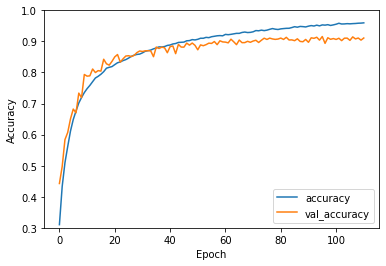

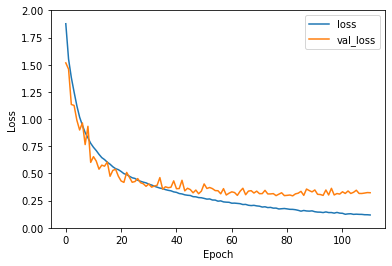

In [53]:

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')
plt.show()

# Plotting trend of loss for the training and validation dataset by epochs
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='upper right')
plt.show()


In [ ]:
# In this experiment, the trained model reaches a maximum of 91.58% accuracy with the validation dataset (5000 images) 
# On the other hand, the accuracy is only 82.13% in the case without dataset augmentation

# As the upper graph, the trend of accuracy for the training and validation dataset increases by epochs
# Moreover, the trend of loss for the training and validation dataset decreases by epochs in the lower graph

# The training phase goes through 111 epochs. The model reaches an accuracy peak at the 96th epoch. 
# In the two above graphs, there is no large variation in the orange line (accuracy and loss of the validation dataset) by the time. 
# This demonstrates that the proposed model is stable and without overfitting phenomenon. 